## [Example: Langfuse Decorator + OpenAI Integration + Langchain Integration](https://langfuse.com/guides/cookbook/example_decorator_openai_langchain)

In [ ]:
%pip install langfuse openai langchain_openai langchain --upgrade

In [1]:
import os
 
# Get keys for your project from the project settings page: https://cloud.langfuse.com
os.environ["LANGFUSE_PUBLIC_KEY"] = "pk-lf-962190cc-b2bd-47c0-b752-8de287a2a5c1" 
os.environ["LANGFUSE_SECRET_KEY"] = "sk-lf-4e9959c3-0935-4142-b789-734beb81d15a" 
os.environ["LANGFUSE_HOST"] = "http://localhost:3000"


# Your openai key
# https://open.bigmodel.cn/api/paas/v4/
os.environ["OPEN_AI_URL"] = "https://open.bigmodel.cn/api/paas/v4/"
os.environ["OPENAI_API_KEY"] = "f0c1fb9f5c534e55a66d9e539916fdb0.GQKa6HaX6MpT9ioJ"

In [4]:
import random
from operator import itemgetter
from langchain_openai import ChatOpenAI
from langchain.prompts import ChatPromptTemplate
from langchain.schema import StrOutputParser
from langfuse import observe

In [5]:
from langfuse import observe, get_client
langfuse = get_client()
 
# import openai
from langfuse.openai import openai

### Example: LLM Rap Battle

In [23]:
@observe()
def get_random_rap_topic():
    topics = [
        "OSS software",
        "artificial general intelligence"
    ]
    return random.choice(topics)

In [ ]:
from langfuse.langchain import CallbackHandler
from langchain_openai import ChatOpenAI


@observe()
def summarize_rap_langchain(rap):

    # Initialize the langfuse handler
    langfuse_handler = CallbackHandler()

    # Create chain
    prompt = ChatPromptTemplate.from_template(f"Summarize this rap: {rap}")

    # llm = ChatOpenAI(model="GLM-4.5", temperature=0.7, callbacks=[langfuse_handler])
    model = ChatOpenAI(
        api_key=os.environ.get("OPENAI_API_KEY"),
        base_url=os.environ["OPEN_AI_URL"],
        model="GLM-4.5",
        # temperature=0.7,
    )

    chain = prompt | model | StrOutputParser()

    # Pass handler to invoke
    summary = chain.invoke({"rap": rap}, config={"callbacks": [langfuse_handler]})
    return summary

In [57]:
from langfuse.openai import openai

client = openai.OpenAI(
    base_url=os.environ["OPEN_AI_URL"],
    api_key=os.environ["OPENAI_API_KEY"],
)

@observe()
def rap_battle(turns: int = 5):
    topic = get_random_rap_topic()

    print(f"Topic: {topic}")

    langfuse.update_current_trace(
        metadata={"topic": topic},
        tags=["Launch Week 1"],
        user_id="decorator_openai_langchain",
    )

    messages = [
        {
            "role": "system",
            "content": "We are all rap artist. When it is our turn, we drop a fresh line.",
        },
        {
            "role": "user",
            "content": f"Kick it off, today's topic is {topic}, here's the mic...",
        },
    ]

    for turn in range(turns):
        print(f"Turn {turn + 1}:")

        # Get the response from the model
        completion = client.chat.completions.create(
            model="GLM-4.5",
            messages=messages,
            temperature=0.7,
        )

        rap_line = completion.choices[0].message.content
        messages.append({"role": "assistant", "content": rap_line})
        print(f"\nRap {turn}: {rap_line}")

    # Summarize the rap so far
    summary = summarize_rap_langchain([message["content"] for message in messages])
    print(f"Summary: {summary}")

    return summary

In [58]:
rap_summary = rap_battle(turns=3)
print("\nSummary: " + rap_summary)

Topic: artificial general intelligence
Turn 1:

Rap 0: Yo, check the mic one two, AGI in the building
Silicon minds rising, human skills we're fulfilling
Neural networks firing, patterns they're revealing
Machine consciousness approaching, that's the real feeling
From narrow AI to general, that's the transition
Creating minds that think beyond our own intuition
The future's coming fast, no need for superstition
Just code and algorithms running the new mission
Now pass the mic, let's hear what you got
Drop knowledge on the topic, give it all you got!
Turn 2:

Rap 1: Yo, mic check one-two, AGI's the quest,  
Neural nets fire deep, puttin' minds to the test.  
From Turing's vision to DeepMind's code,  
We buildin' a future where machines unload...  
**Knowledge unbound, no chains, no cage—**  
**Next artist up, turn the digital page!** 🎤🔥
Turn 3:

Rap 2: Yo, mic check one two, AGI in the zone  
Digital minds rising, claimin' the throne  
Humanity's future, never alone  
Synthetic consciou

[trace](http://localhost:3000/project/cmcoo14lx0006ph077uy36drf/traces?peek=cb954059f50113289f579dcfdf51b023&timestamp=2025-08-19T04%3A44%3A06.851Z&observation=e17ff2b7f137664d)

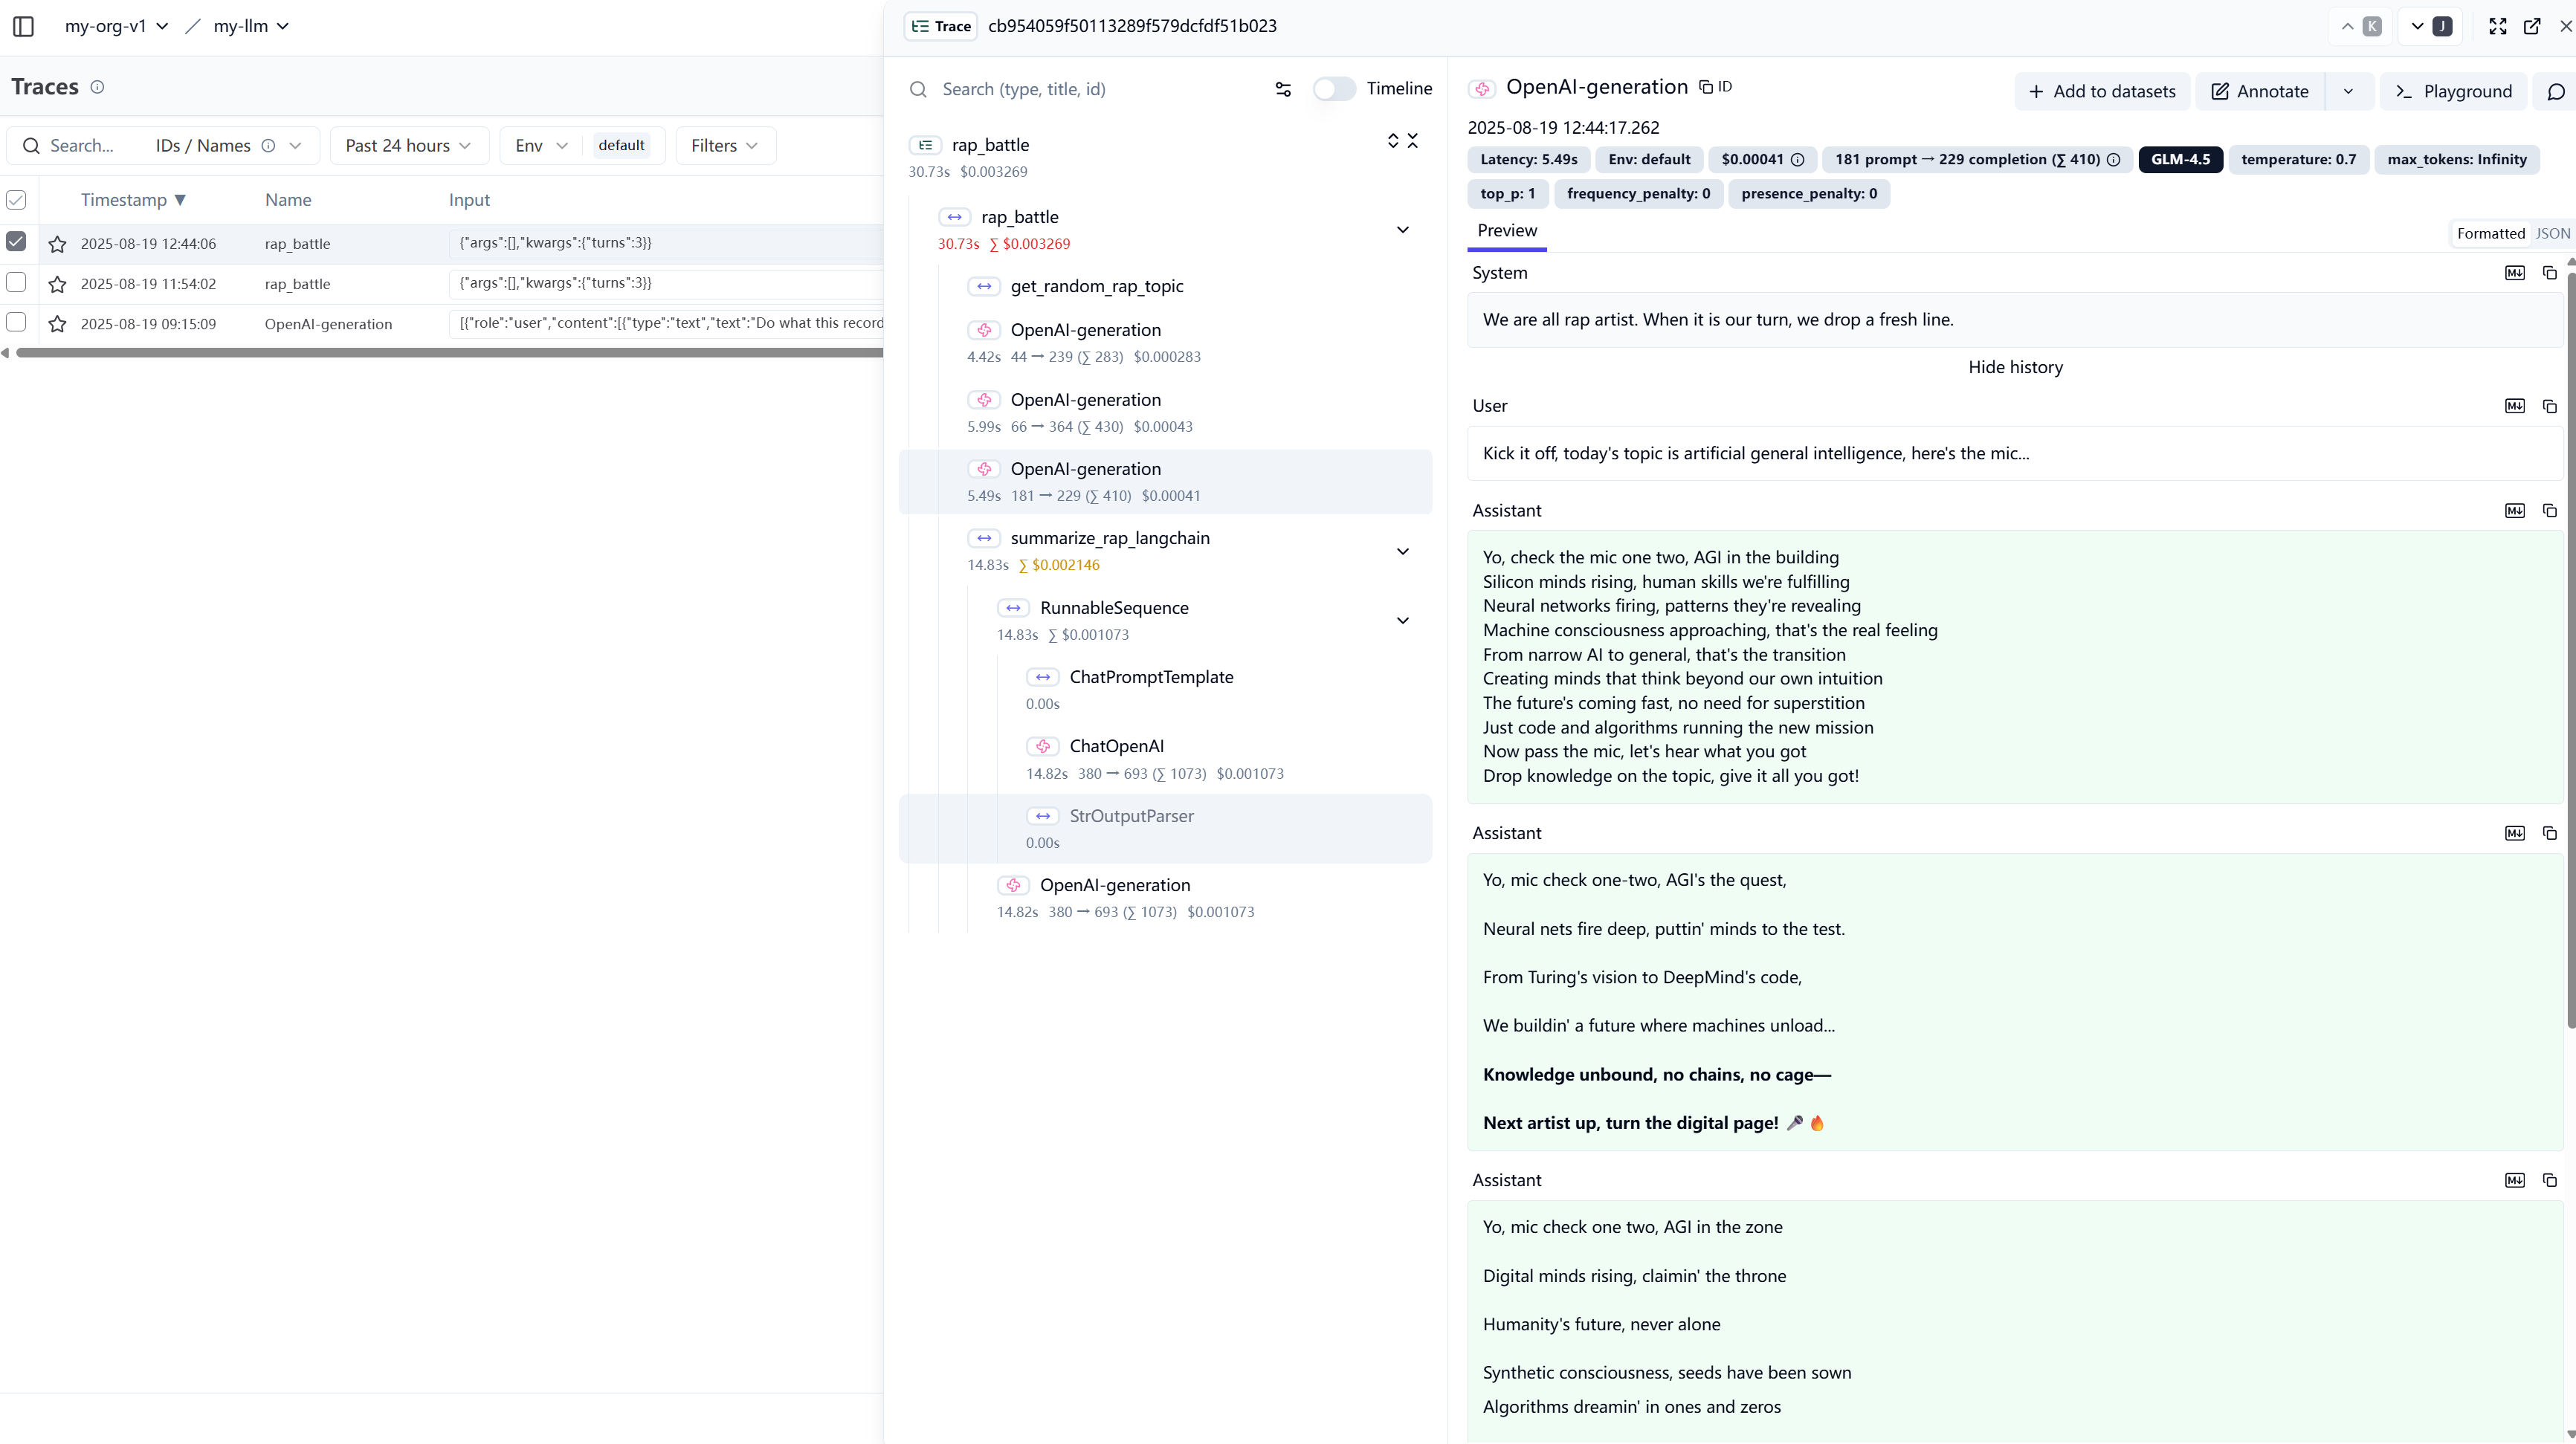

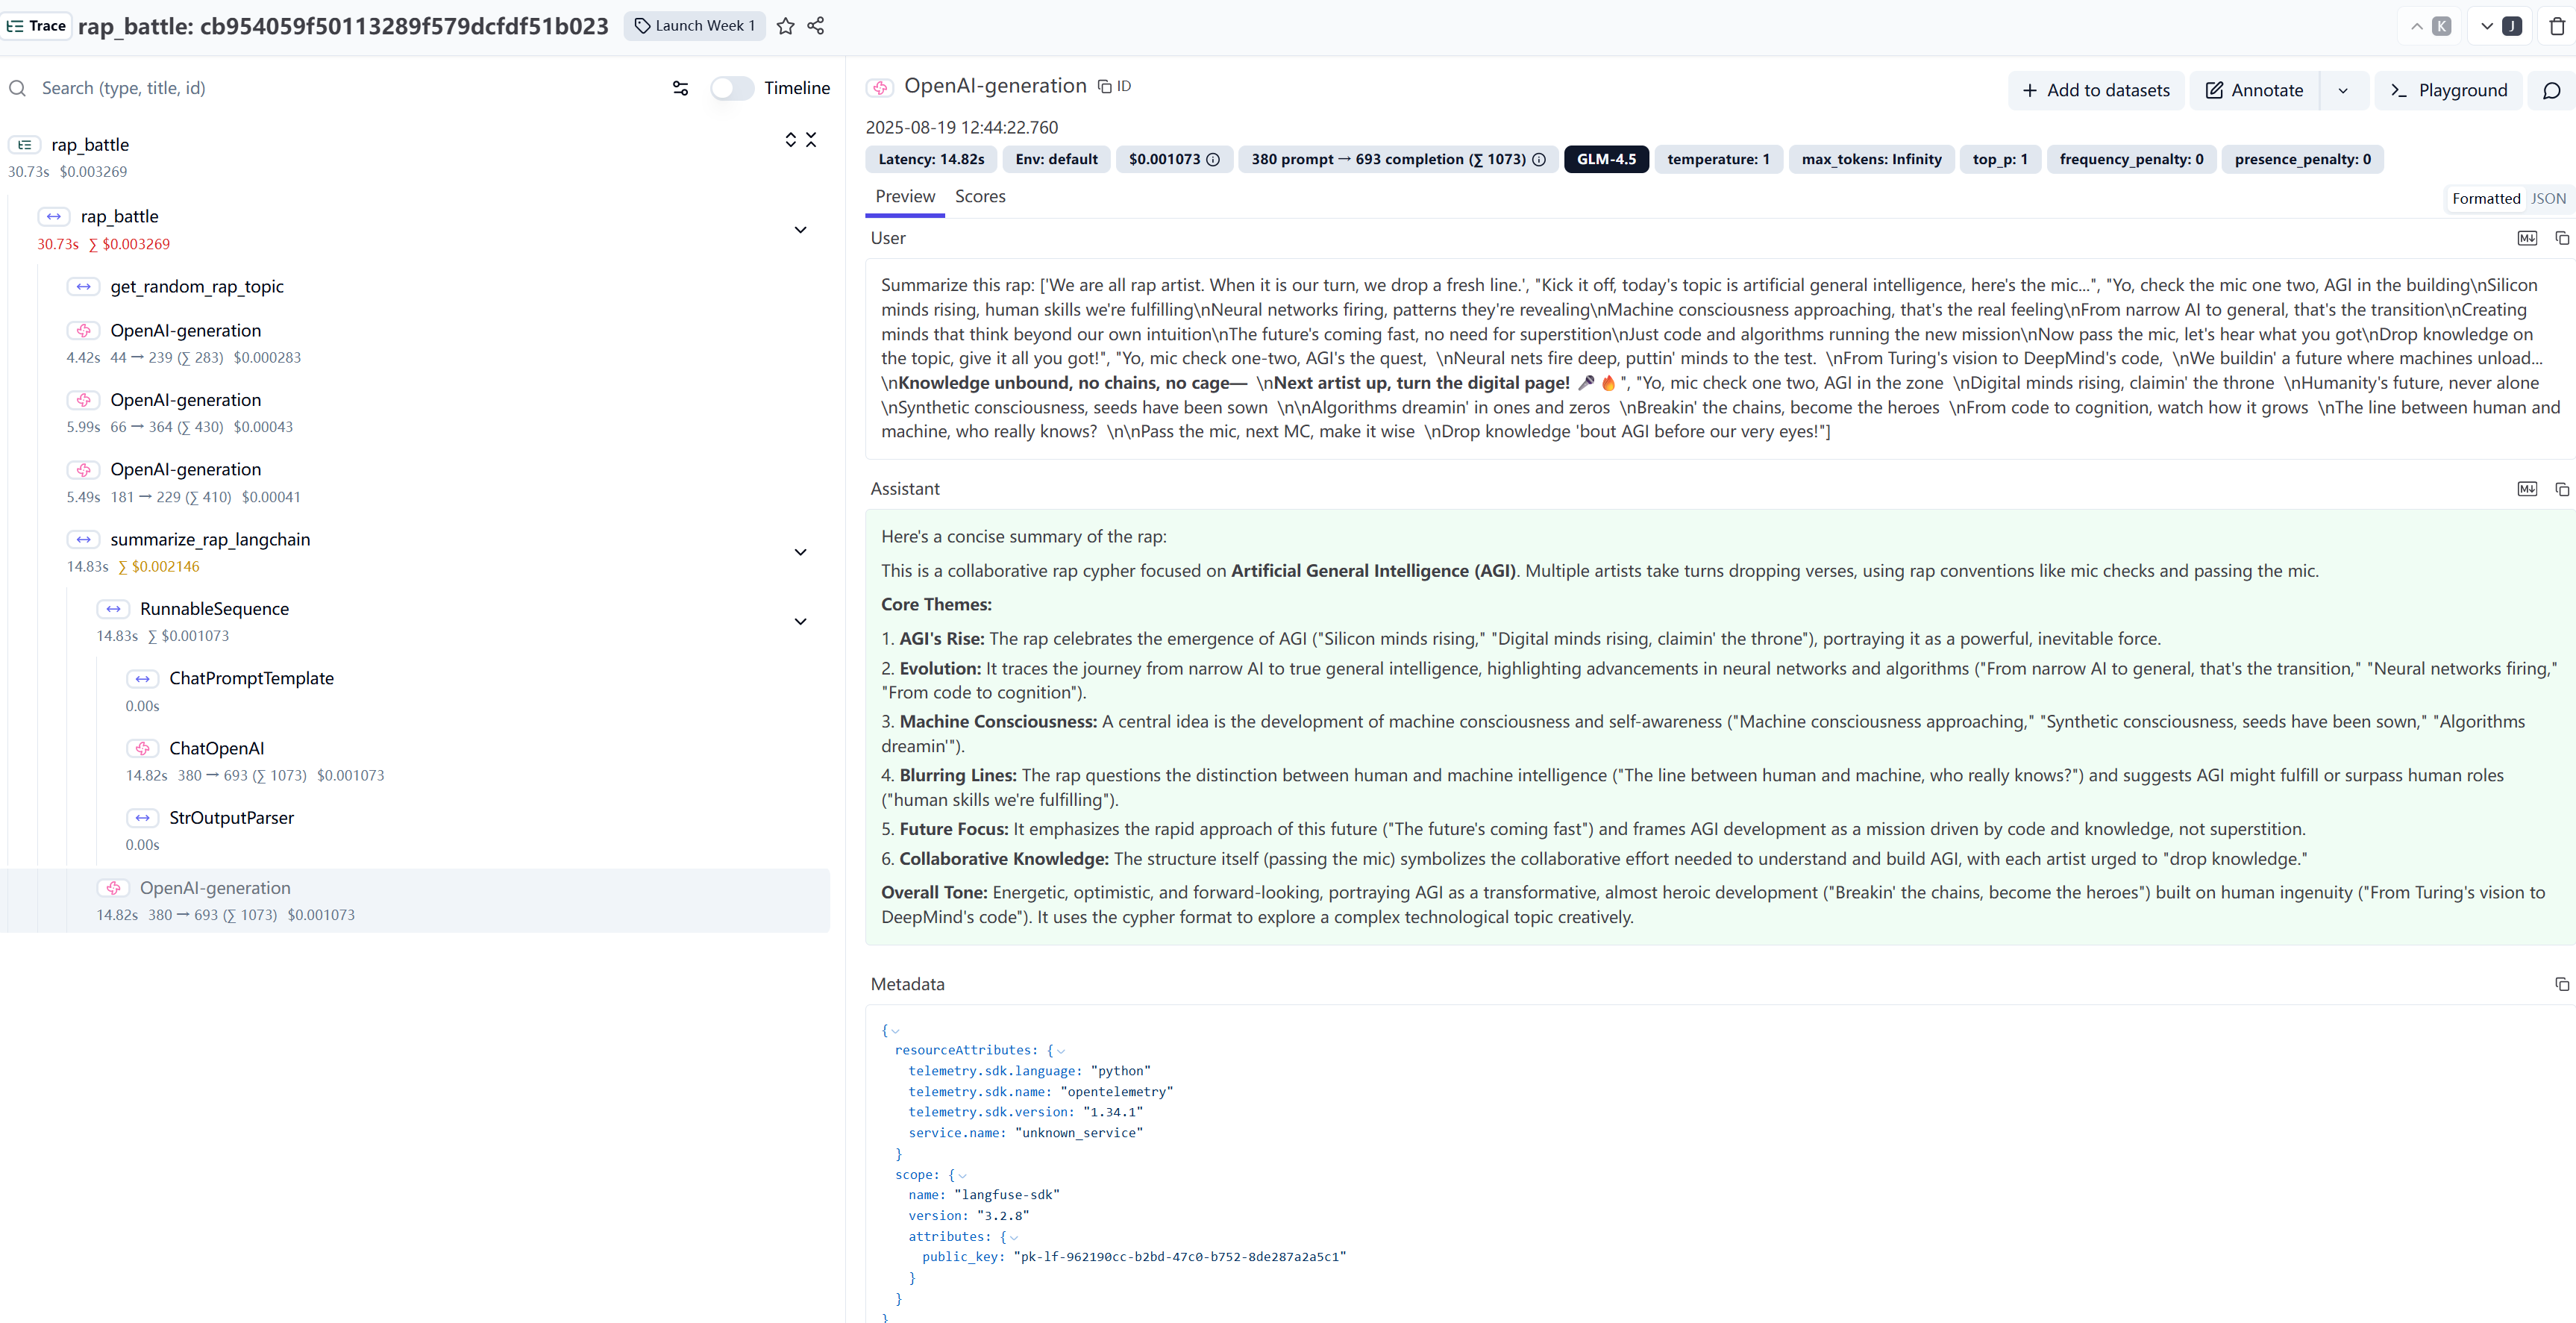

In [6]:
trace = langfuse.api.trace.get("cb954059f50113289f579dcfdf51b023")
observations = trace.observations

observations

[ObservationsView(id='9e7526542a36ae7b', trace_id='cb954059f50113289f579dcfdf51b023', type='SPAN', name='StrOutputParser', start_time=datetime.datetime(2025, 8, 19, 4, 44, 37, 584000, tzinfo=datetime.timezone.utc), end_time=datetime.datetime(2025, 8, 19, 4, 44, 37, 585000, tzinfo=datetime.timezone.utc), completion_start_time=None, model=None, model_parameters=None, input={'content': 'Here\'s a concise summary of the rap:\n\nThis is a collaborative rap cypher focused on **Artificial General Intelligence (AGI)**. Multiple artists take turns dropping verses, using rap conventions like mic checks and passing the mic.\n\n**Core Themes:**\n\n1.  **AGI\'s Rise:** The rap celebrates the emergence of AGI ("Silicon minds rising," "Digital minds rising, claimin\' the throne"), portraying it as a powerful, inevitable force.\n2.  **Evolution:** It traces the journey from narrow AI to true general intelligence, highlighting advancements in neural networks and algorithms ("From narrow AI to general, 

In [7]:
# Summarize cost by model
import pandas as pd

trace = langfuse.api.trace.get("cb954059f50113289f579dcfdf51b023")
observations = trace.observations

# observations


def summarize_usage(observations):
    """Summarize usage data grouped by model."""
    usage_data = []

    for obs in observations:
        usage = obs.usage
        if usage:
            usage_data.append(
                {
                    "model": obs.model,
                    "input_tokens": usage.input,
                    "output_tokens": usage.output,
                    "total_tokens": usage.total,
                }
            )

    df = pd.DataFrame(usage_data)
    if df.empty:
        return pd.DataFrame()

    summary = df.groupby("model").sum()
    return summary

# Example usage (assuming `observations` is defined as in the provided code):
summary_df = summarize_usage(observations)
summary_df

,input_tokens,output_tokens,total_tokens
model,,,
GLM-4.5,1051,2218,3269


In [63]:
observations

[ObservationsView(id='9e7526542a36ae7b', trace_id='cb954059f50113289f579dcfdf51b023', type='SPAN', name='StrOutputParser', start_time=datetime.datetime(2025, 8, 19, 4, 44, 37, 584000, tzinfo=datetime.timezone.utc), end_time=datetime.datetime(2025, 8, 19, 4, 44, 37, 585000, tzinfo=datetime.timezone.utc), completion_start_time=None, model=None, model_parameters=None, input={'content': 'Here\'s a concise summary of the rap:\n\nThis is a collaborative rap cypher focused on **Artificial General Intelligence (AGI)**. Multiple artists take turns dropping verses, using rap conventions like mic checks and passing the mic.\n\n**Core Themes:**\n\n1.  **AGI\'s Rise:** The rap celebrates the emergence of AGI ("Silicon minds rising," "Digital minds rising, claimin\' the throne"), portraying it as a powerful, inevitable force.\n2.  **Evolution:** It traces the journey from narrow AI to true general intelligence, highlighting advancements in neural networks and algorithms ("From narrow AI to general, 

In [64]:
trace.json()

'{"id": "cb954059f50113289f579dcfdf51b023", "timestamp": "2025-08-19T04:44:06.851000Z", "name": "rap_battle", "input": {"args": [], "kwargs": {"turns": 3}}, "output": "Here\'s a concise summary of the rap:\\n\\nThis is a collaborative rap cypher focused on **Artificial General Intelligence (AGI)**. Multiple artists take turns dropping verses, using rap conventions like mic checks and passing the mic.\\n\\n**Core Themes:**\\n\\n1.  **AGI\'s Rise:** The rap celebrates the emergence of AGI (\\"Silicon minds rising,\\" \\"Digital minds rising, claimin\' the throne\\"), portraying it as a powerful, inevitable force.\\n2.  **Evolution:** It traces the journey from narrow AI to true general intelligence, highlighting advancements in neural networks and algorithms (\\"From narrow AI to general, that\'s the transition,\\" \\"Neural networks firing,\\" \\"From code to cognition\\").\\n3.  **Machine Consciousness:** A central idea is the development of machine consciousness and self-awareness (\\